<h1>Audio Signal Processing. (MFC, MFCCs)<h1>
<h1>Audio Identification & Classification<h1>

<h2>STEP1: Audio Signal Processing<h2>


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import os
import librosa
from tqdm import tqdm
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from scipy.io import wavfile as wav

import keras
from keras._tf_keras.keras.utils import to_categorical
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import Dense, Activation, Flatten, Dropout
from keras._tf_keras.keras.optimizers import Adam
from keras._tf_keras.keras.callbacks import ModelCheckpoint
print(keras.__version__)


3.4.1


In [2]:
#Firstly let's look how librosa handles sound signals
#Read an example audio signal using librosa
audio_path = 'UrbanSound8K/17973-2-0-32.wav'
librosa_audio_data, librosa_sample_rate = librosa.load(audio_path)

In [3]:
#Mono
print('Librosa Audio Sample Shape:', librosa_audio_data.shape)
print('Librosa Audio Sample Rate:', librosa_sample_rate)
print('Librosa Audio Sample Data:', librosa_audio_data)

Librosa Audio Sample Shape: (88200,)
Librosa Audio Sample Rate: 22050
Librosa Audio Sample Data: [ 0.0591024   0.04647241 -0.02115159 ... -0.00696119  0.03259261
  0.09148587]


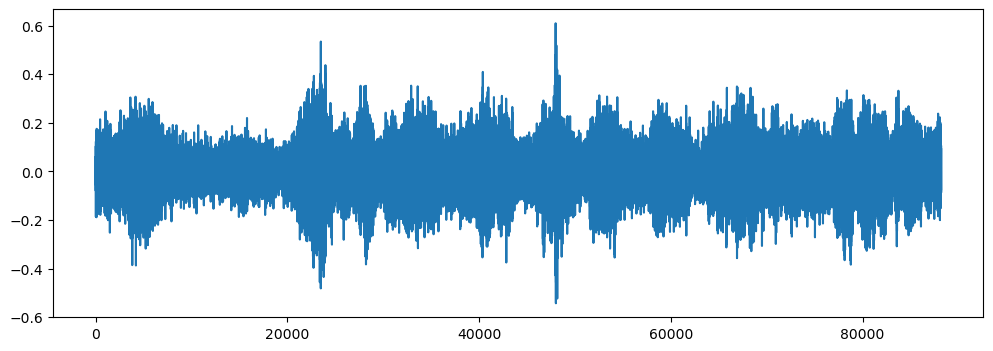

In [4]:
#Plot the sample audio data
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)
plt.show()

In [5]:
#Read with scipy
wave_sample_rate, wave_audio = wav.read(audio_path)

In [6]:
#Sterio
wave_audio

array([[2189, 3314],
       [1592, 2598],
       [ 848, 1712],
       ...,
       [1326, 2602],
       [1915, 3542],
       [2542, 4449]], dtype=int16)

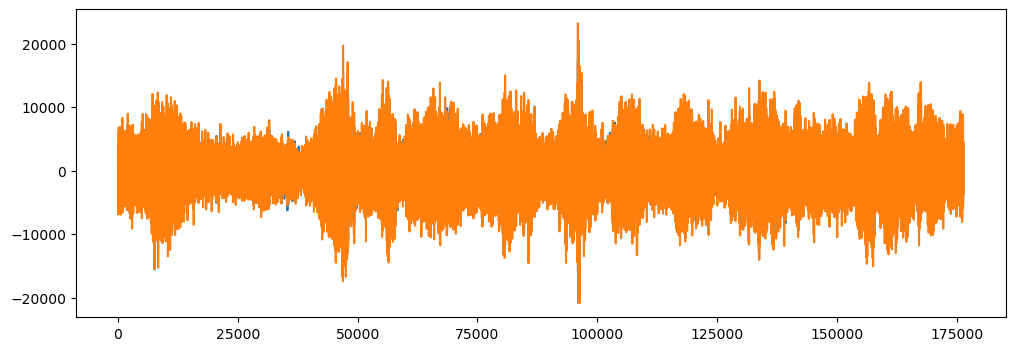

In [7]:
#Original audio with 2 channels
plt.figure(figsize=(12,4))
plt.plot(wave_audio)
plt.show()

In [8]:
#Feature extraction
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 173)


In [9]:
mfccs

array([[-166.06232  , -151.50262  , -172.7387   , ..., -192.53252  ,
        -179.10655  , -179.59177  ],
       [  75.67847  ,   93.39499  ,  109.314476 , ...,  107.66586  ,
          87.264244 ,   67.258606 ],
       [-107.50531  , -118.78258  , -128.7536   , ..., -112.772415 ,
         -97.96594  ,  -85.718735 ],
       ...,
       [  -9.795132 ,   -8.94021  ,  -14.13222  , ...,   -6.595042 ,
          -2.1138773,   -5.715401 ],
       [   5.047469 ,    3.6141448,    5.1923428, ...,   -4.6435246,
         -11.839522 ,  -17.177223 ],
       [   4.929693 ,    7.551    ,    7.043155 , ...,   -2.6938517,
          -6.542886 ,   -7.347313 ]], dtype=float32)

In [10]:
#Now extract MFCC's for every audio file in the dataset
audio_dataset_path='UrbanSound8K/audio/'
metadata=pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [11]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features


In [12]:
extracted_features=[]
for index_num, row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path), 'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data = features_extractor(file_name)
    extracted_features.append([data, final_class_labels])

3554it [03:21, 17.94it/s]/Users/halil/opt/anaconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
8325it [07:46, 23.53it/s]/Users/halil/opt/anaconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/Users/halil/opt/anaconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
8732it [08:09, 17.84it/s]


<h2>STEP2: Audio Identification & Classification<h2>

In [13]:
#Convert extracted features to Pandas data frame
ex_features_df = pd.DataFrame(extracted_features, columns=['feature', 'class'])
#Check df
ex_features_df.head()

,feature,class
0,"[-217.35526, 70.22338, -130.38527, -53.282898,...",dog_bark
1,"[-424.09818, 109.34077, -52.919525, 60.86475, ...",children_playing
2,"[-458.79114, 121.38419, -46.52066, 52.00812, -...",children_playing
3,"[-413.89984, 101.66371, -35.42945, 53.036358, ...",children_playing
4,"[-446.60352, 113.68541, -52.402214, 60.302044,...",children_playing


In [14]:
#Split the dataset into independent and dependent dataset
X = np.array(ex_features_df['feature'].tolist())
y = np.array(ex_features_df['class'].tolist())

In [15]:
X.shape

(8732, 40)

In [16]:
#Label encoding (one-hot?)
label_encoder = LabelEncoder()
y=to_categorical(label_encoder.fit_transform(y))

In [20]:
y[0] #dog bark

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [21]:
#Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [22]:
X_train

array([[-1.3110471e+02,  1.1250591e+02, -2.2574696e+01, ...,
         3.2466526e+00, -1.3690237e+00,  2.7557547e+00],
       [-1.3670342e+01,  9.1085083e+01, -7.7927332e+00, ...,
        -3.2530508e+00, -5.2774525e+00, -1.5569715e+00],
       [-4.9871544e+01,  2.6535299e-01, -2.0500937e+01, ...,
         2.8545945e+00, -1.6092046e+00,  3.5248058e+00],
       ...,
       [-4.2701236e+02,  9.2623047e+01,  3.1293974e+00, ...,
         7.4264127e-01,  7.3349088e-01,  7.1100914e-01],
       [-1.4575461e+02,  1.3626578e+02, -3.3515522e+01, ...,
         1.4681193e+00, -2.0091701e+00, -8.8218188e-01],
       [-4.2103134e+02,  2.1065454e+02,  3.4906609e+00, ...,
        -5.3888674e+00, -3.3713608e+00, -1.5665114e+00]], dtype=float32)

In [23]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [24]:
X_train.shape

(6985, 40)

In [25]:
X_test.shape

(1747, 40)

In [26]:
#Building CNN model and train
num_labels = 10

In [27]:
model = Sequential()
#1.hidden layer
model.add(Dense(125, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
#2.hidden layer
model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dropout(0.5))
#3.hidden layer
model.add(Dense(125))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#Output layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

/Users/halil/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 125)            │         5,125 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 125)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 125)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 250)            │        31,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 125)            │        31,375 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 125)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 125)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,260 (270.55 KB)

 Trainable params: 69,260 (270.55 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
#Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [30]:
epoch_count = 300
num_batch_size = 32
#Train the model
model.fit(X_train,y_train,batch_size=num_batch_size,epochs=epoch_count,validation_data=(X_test, y_test), verbose=1)


Epoch 1/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1238 - loss: 19.9374 - val_accuracy: 0.1236 - val_loss: 2.2781
Epoch 2/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1290 - loss: 2.5378 - val_accuracy: 0.1168 - val_loss: 2.1870
Epoch 3/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1581 - loss: 2.2703 - val_accuracy: 0.1940 - val_loss: 2.1255
Epoch 4/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1862 - loss: 2.1865 - val_accuracy: 0.2622 - val_loss: 2.0227
Epoch 5/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2160 - loss: 2.1354 - val_accuracy: 0.2685 - val_loss: 1.9603
Epoch 6/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2160 - loss: 2.0902 - val_accuracy: 0.3165 - val_loss: 1.9056
Epoch 7/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2396 - loss: 2.0444 - val_accuracy: 0.3091 - val_loss: 1.9014
Epoch 8/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2414 - loss: 2.0139 - val_acc

Text(0, 0.5, 'Accuracy')

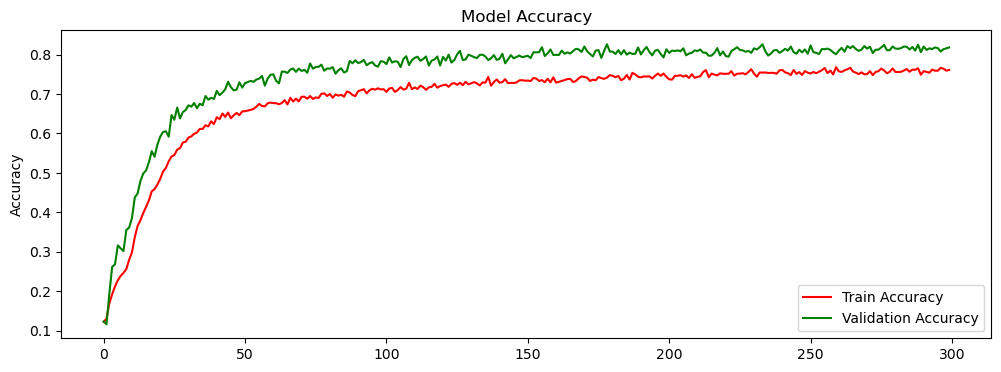

In [33]:
#Sketch the acc
plt.figure(figsize=(12,4))
plt.plot(model.history.history['accuracy'], color='r', label='Train Accuracy')
plt.plot(model.history.history['val_accuracy'], color='g', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')

In [36]:
#Calculate f-1 score, recall and precision
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

f1_score = metrics.f1_score(y_true_classes, y_pred_classes, average='weighted')
recall = metrics.recall_score(y_true_classes, y_pred_classes, average='weighted')
precision = metrics.precision_score(y_true_classes, y_pred_classes, average='weighted')

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [37]:
print('F1 Score:', f1_score)
print('Recall:', recall)
print('Precision:', precision)

F1 Score: 0.8188548753026706
Recall: 0.8179736691471093
Precision: 0.8312595780350408


In [38]:
#Test with a manuel input
file_name = "PoliceSiren.wav"
soun_signal, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
mfccs_features = librosa.feature.mfcc(y=soun_signal, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)


In [39]:
print(mfccs_scaled_features)

[-5.0995752e+02  5.8146946e+01 -2.6707426e+01 -1.7372311e+01
 -2.8753526e+00  1.1949612e+01  3.4049835e+01  2.4762630e+01
  4.6244879e+00  3.2124473e-03  4.9547729e+00  1.8490025e+00
 -1.0731525e+01 -1.1760647e+01 -9.5060568e+00 -1.4619814e+01
 -1.1907404e+01 -7.1366186e+00 -6.3352227e+00 -2.0210277e-01
  1.8496815e+00 -4.4661732e+00 -6.6702261e+00 -4.1697803e+00
 -8.3460444e-01  1.0379703e+00 -1.6958172e+00 -3.1239166e+00
  6.9476920e-01  4.1810641e+00  6.1519122e-01 -7.5993414e+00
 -7.3442678e+00 -1.6432670e+00 -1.6267995e+00 -1.0078022e+00
 -7.9470462e-01 -3.7893722e+00 -2.6085303e+00 -2.7019656e+00]


In [40]:
mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)
mfccs_scaled_features.shape

(1, 40)

In [41]:
print(mfccs_scaled_features)

[[-5.0995752e+02  5.8146946e+01 -2.6707426e+01 -1.7372311e+01
  -2.8753526e+00  1.1949612e+01  3.4049835e+01  2.4762630e+01
   4.6244879e+00  3.2124473e-03  4.9547729e+00  1.8490025e+00
  -1.0731525e+01 -1.1760647e+01 -9.5060568e+00 -1.4619814e+01
  -1.1907404e+01 -7.1366186e+00 -6.3352227e+00 -2.0210277e-01
   1.8496815e+00 -4.4661732e+00 -6.6702261e+00 -4.1697803e+00
  -8.3460444e-01  1.0379703e+00 -1.6958172e+00 -3.1239166e+00
   6.9476920e-01  4.1810641e+00  6.1519122e-01 -7.5993414e+00
  -7.3442678e+00 -1.6432670e+00 -1.6267995e+00 -1.0078022e+00
  -7.9470462e-01 -3.7893722e+00 -2.6085303e+00 -2.7019656e+00]]


In [42]:
result_array = model.predict(mfccs_scaled_features)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [43]:
result_array

array([[2.0318798e-26, 8.5474413e-14, 1.8945459e-14, 2.1043461e-06,
        3.5713091e-14, 3.3741449e-16, 5.6690035e-12, 4.4273832e-25,
        9.9999785e-01, 9.9869609e-12]], dtype=float32)

In [44]:
result_classes = ["air_conditioner", "car_horn", "children_playing", "dog_bark", "drilling","engine_idling","gun_shot","jackhammer", "siren","street_music"]
result = np.argmax(result_array[0])
print(f"The predicted class is: {result_classes[result]}")

The predicted class is: siren
